<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/02-running-inference/01_running_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPT-Neo inference with the HF's Transformers Library

The code in this notebook is to introduce readers to the inference (text generation) with the [GPT-Neo model](https://github.com/EleutherAI/gpt-neo) using the Hugging Face's [Transformers library](https://github.com/huggingface/transformers). It can be executed in the Colab free tier with hardware acceleration (GPU).  

Install the missing requirements in the Colab VM (HF's Accelerate only).

In [ ]:
!pip install -q accelerate

Download the GPT-Neo 2.7B model and the associated tokenizer from the HF's Hub. The model is loaded in full precision and is then loaded into the GPU.

The formula to calculate how much
memory (in GB) is required for inference is the following:

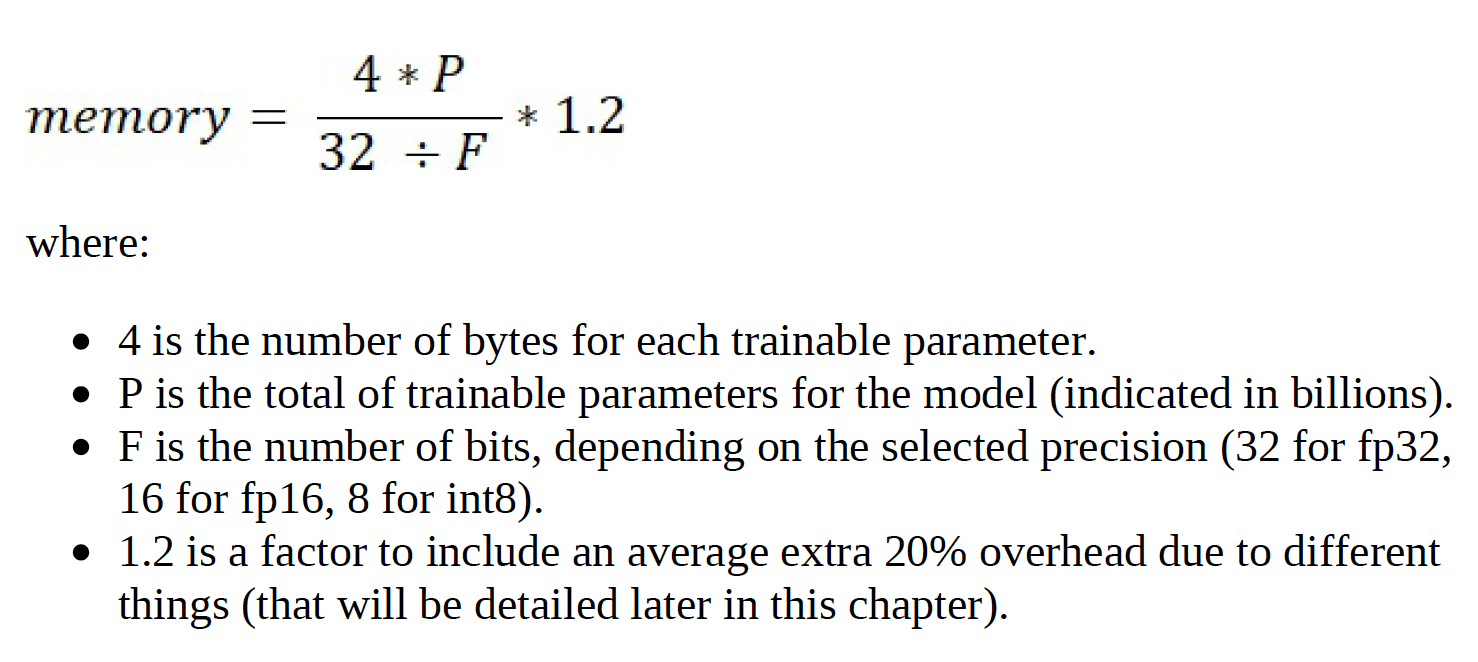

In [5]:
P = 2.7
F = 32
required_memory = ((4 * P) / (32 / F)) * 1.2
print(f"Required memory: {round(required_memory, 2)} GB")

Required memory: 12.96 GB


In [ ]:
import torch
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "EleutherAI/gpt-neo-2.7B"
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
model = GPTNeoForCausalLM.from_pretrained(model_id, device_map="auto")
model.to(device)

```log
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj): Linear(in_features=10240, out_features=2560, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2560, out_features=50257, bias=False)
)
```

Verify where the model layers have been loaded (all in the GPU memory or also RAM and/or disk).

In [6]:
model.hf_device_map

{'': 0}

Perform standard inference (text completion).

In [7]:
prompt = "The story so far: in the beginning, the universe was created."
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(input_ids,
                               do_sample=True,
                               temperature=0.9,
                               max_length=200,
                               pad_token_id=50256)
generated_text = tokenizer.decode(generated_ids[0])
print(generated_text)

The story so far: in the beginning, the universe was created. This is a tale of love, a woman and a man. There was nothing else to it, so the two of them did things. They made babies. They made memories, and then they made more babies. And then they made more memories, and so on. And eventually, the universe exploded and went down in a fiery ball of light.

This is the first of our four books in the Chronicles of a Family of Men.

This is the first of our four books in the Chronicles of a Family of Men.

By my mother’s grandfather’s father’s grandfather’s father

This is the first of our four books in the Chronicles of a Family of Men.

And by my mother’s grandfather’s father’s grandfather’s father

This is the first of our four books in the Chronicles of a Family


## Few-shot learning

Do few-shot text classification (the model can generalize learning from few new and unseen examples.

In [8]:
prompt = """
Sentence: This movie is very nice.
Sentiment: positive

#####

Sentence: I hated this movie, it sucks.
Sentiment: negative

#####

Sentence: This movie was actually pretty funny.
Sentiment: positive

#####

Sentence: This movie could have been better.
Sentiment: neutral
"""
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(input_ids,
                               do_sample=True,
                               temperature=0.9,
                               max_length=200,
                               pad_token_id=50256)
generated_text = tokenizer.decode(generated_ids[0])
print(generated_text)


Sentence: This movie is very nice.
Sentiment: positive

#####

Sentence: I hated this movie, it sucks.
Sentiment: negative

#####

Sentence: This movie was actually pretty funny.
Sentiment: positive

#####

Sentence: This movie could have been better.
Sentiment: neutral

#####

Sentence: I think this movie was actually pretty good.
Sentiment: positive

#####

Sentence: I thought that was hilarious.
Sentiment: positive

#####

Sentence: This movie was really good.
Sentiment: neutral

#####

Sentence: I thought this movie was pretty good.
Sentiment: neutral

#####

Sentence: This movie was really good.
Sentiment: positive

#####

Sentence: This movie was really good.



## Code generation

In [9]:
prompt = """Instruction: Generate a Python function that lets you reverse a list of integers.

Answer: """
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

generated_ids = model.generate(input_ids,
                               do_sample=True,
                               temperature=0.9,
                               max_length=200,
                               pad_token_id=50256
                               )
generated_text = tokenizer.decode(generated_ids[0])
print(generated_text)

Instruction: Generate a Python function that lets you reverse a list of integers.

Answer:  

  ```Python
  def _inversed_list(t):
    return [t[0], t[-1], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8], t[9], \
                                t[10], t[11], t[12], t[13], t[14], t[15], t[16], \
                                t[17], t[18], t[19], t[20


## Batch Prompting

Do batch text completion.

In [10]:
texts = ["Once there was a man ", "The weather today will be ", "A great soccer player must "]

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
encoding = tokenizer(texts, padding=True, return_tensors='pt').to(device)
with torch.no_grad():
    generated_ids = model.generate(**encoding,
                                   do_sample=True,
                                   temperature=0.9,
                                   max_length=50,
                                   pad_token_id=50256)
generated_texts = tokenizer.batch_decode(
    generated_ids, skip_special_tokens=True)

for text in generated_texts:
  print("---------")
  print(text)

---------
Once there was a man   
Who believed in me,   
The world could never have heard such a good word said.   
But it was not I who said it, but this man   

---------
The weather today will be  hot and sunny, so it's time to think about sun safety. 

  *  _Keep your bedroom door closed and windows shut_ This is one of the easiest ways to avoid sunburn.

  *
---------
A great soccer player must _____ to improve his _______.
A fine teacher must _____ to keep his _____ alive.
A fine teacher must _____ to stay on the same team.
A fine teacher must _____ to be


## Evaluating LLM

In [ ]:
%%shell

git clone --depth 1 https://github.com/EleutherAI/lm-evaluation-harness
cd lm-evaluation-harness
pip install -e .

In [ ]:
!lm_eval \
  --model hf-auto \
  --model_args pretrained=EleutherAI/gpt-neo-2.7B,dtype="float16" \
  --tasks wikitext \
  --device cuda:0

2025-09-23 05:57:25.102717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758607045.133734    9967 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758607045.143366    9967 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758607045.166206    9967 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758607045.166239    9967 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758607045.166248    9967 computation_placer.cc:177] computation placer alr

## KV Caching

Benchmarking the model on text completion: comparing the cases where the KV cache is used to those where it isn't.

In [11]:
import time
import numpy as np

prompt = "The story so far: in the beginning, the universe was created."
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

for use_cache in (True, False):
  times = []
  for _ in range(20):
    start = time.time()
    generated_ids = model.generate(input_ids,
                                  do_sample=True,
                                  temperature=0.9,
                                  max_length=200,
                                  pad_token_id=50256,
                                  use_cache=use_cache)
    times.append(time.time() - start)
  print(f"{'Using' if use_cache else 'No'} KV cache: {round(np.mean(times), 3)} +- {round(np.std(times), 3)} seconds")

Using KV cache: 10.613 +- 1.23 seconds
No KV cache: 49.196 +- 0.221 seconds


Now let’s go back to calculate the arithmetic intensity for our use case. The
formula for the Multi-head Attention is the following:

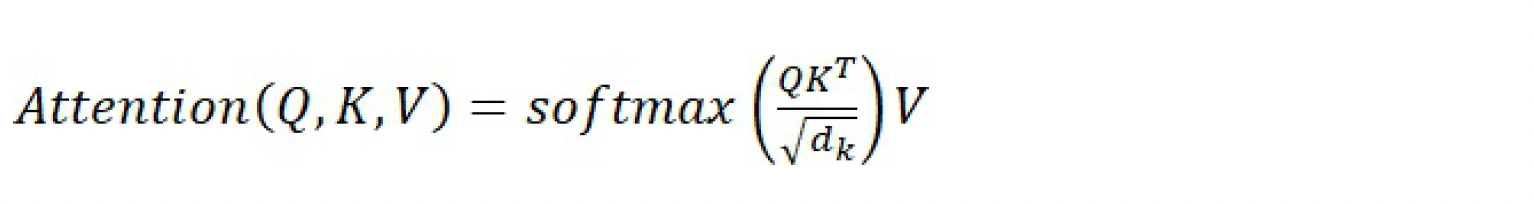

If we had to represent the formula above as an algorithm in pseudo-code, it would be something like this:

```python
Require: Matrices Q, K, V ∈ RNxd in memory.
Step 1: Load Q, K from memory, then compute S = QKT and write it to memory.
Step 2: Read S from memory, then compute P = softmax(S) and write it to memory.
Step 3: Load P and V from memory, then compute O = P x V and write
```

* Some details about other variable appearing in this
algorithm: N is the context window for the model (2048 for the GPT-Neo model), while d is the dimension of a single attention head (for GPT-Neo is 128).

* The dimension of the Q, K and V matrices are then 2048 x 128.

* The S and P matrices have dimension 2048 x 2048.
* The O matrix has then dimension 2048 x 128.


The arithmetic intensity depends on the total memory
movement and the total compute.

Considering the three operations involved
in each step of the algorithm under examination, the formulas to calculate these values are (the first one is expressed in bytes, the other one in FLOPS):



In [16]:
N = 2048
d = 128
P = N * N
S = N * N

total_memory_movement = (2 * 4 * (N * d)) + (4 * S) + (4 * (P + (N * d)))
total_compute = ((2 * d) * S) + (3 * P) + ((2 * N) * (N *d))

The arithmetic intensity can then be calculated this way:

In [19]:
arithmetic_intensity = total_compute / total_memory_movement

print(f"total_memory_movement: {round(total_memory_movement, 3)} bytes")
print(f"total_compute: {round(total_compute, 3)} FLOPS")
print(f"arithmetic_intensity: {round(arithmetic_intensity, 3)} ops/byte")

total_memory_movement: 36700160 bytes
total_compute: 2160066560 FLOPS
arithmetic_intensity: 58.857 ops/byte


## Estimating the generation time

Benchmarking the model's total generation time.

In [ ]:
import time
import numpy as np

prompt = "The story so far: in the beginning, the universe was created."
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

max_length = 300
times = []
inference_runs = 21
for _ in range(inference_runs):
  start = time.time()
  generated_ids = model.generate(input_ids,
                                do_sample=True,
                                temperature=0.9,
                                max_length=max_length,
                                pad_token_id=50256,
                                )
  times.append(time.time() - start)
print(f"Average Total Generation time: {round(np.mean(times[1:]), 3)} +- {round(np.std(times[1:]), 3)} seconds")